# Example Demonstrating the improved NMLL of learned base kernel parameters

In [31]:
%run imports.py

np.random.seed(4)
tf.random.set_seed(4)

All packages loaded successfully.


In [32]:
class CustomAdditiveKernel(gpflow.kernels.Kernel):
    """
    Implements the kernel k(x,x') = sigma0_sq + sigma1_sq * (k1 + k2) + sigma2_sq * (k1 * k2)
    - k1, k2 are RBF kernels with their own variance and lengthscale.
    - sigma0_sq, sigma1_sq, sigma2_sq are additional trainable variance parameters.
    """
    def __init__(self):
        super().__init__()
        self.k1 = gpflow.kernels.RBF(active_dims=[0])
        self.k2 = gpflow.kernels.RBF(active_dims=[1])

        # Trainable variance parameters for each interaction order.
        self.sigma0_sq = gpflow.Parameter(1.0, transform=positive())
        self.sigma1_sq = gpflow.Parameter(1.0, transform=positive())
        self.sigma2_sq = gpflow.Parameter(1.0, transform=positive())

    def K(self, X, X2=None):
        
        k1_matrix = self.k1(X, X2)
        k2_matrix = self.k2(X, X2)

        return (self.sigma0_sq + self.sigma1_sq * (k1_matrix + k2_matrix) + self.sigma2_sq * (k1_matrix * k2_matrix))

    def K_diag(self, X):

        k1_diag = self.k1.K_diag(X)
        k2_diag = self.k2.K_diag(X)
        
        return (self.sigma0_sq + self.sigma1_sq * (k1_diag + k2_diag) + self.sigma2_sq * (k1_diag * k2_diag))

class BiasKernel(gpflow.kernels.Kernel):
    def __init__(self, sigma_sq):
        super().__init__()
        self.sigma_sq = tf.constant(sigma_sq, dtype=gpflow.default_float())

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.sigma_sq * tf.ones((tf.shape(X)[0], tf.shape(X2)[0]), dtype=gpflow.default_float())

    def K_diag(self, X):
        return self.sigma_sq * tf.ones(tf.shape(X)[0], dtype=gpflow.default_float())


class MainEffectKernel(gpflow.kernels.Kernel):
    def __init__(self, base_kernel, sigma_sq):
        super().__init__()
        self.base_kernel = base_kernel
        self.sigma_sq = tf.constant(sigma_sq, dtype=gpflow.default_float())

    def K(self, X, X2=None):
        return self.sigma_sq * self.base_kernel(X, X2)

    def K_diag(self, X):
        return self.sigma_sq * self.base_kernel.K_diag(X)


class InteractionKernel(gpflow.kernels.Kernel):
    def __init__(self, k1, k2, sigma_sq):
        super().__init__()
        self.k1 = k1
        self.k2 = k2
        self.sigma_sq = tf.constant(sigma_sq, dtype=gpflow.default_float())

    def K(self, X, X2=None):
        return self.sigma_sq * (self.k1(X, X2) * self.k2(X, X2))

    def K_diag(self, X):
        return self.sigma_sq * (self.k1.K_diag(X) * self.k2.K_diag(X))


In [34]:
# --- Generate synthetic 2D data ---
def true_function(X):
    x1, x2 = X[:,0], X[:,1]
    return 10*x1**2 + 0.1*np.sin(5*x2)

true_f1 = lambda x: np.sin(2*x)
true_f2 = lambda x: 3*x**3
true_f12 = lambda X: X[:,0]*np.sin(2*X[:,1])


n = 1000
noise = 0.01
X = np.random.normal(0, 1, size=(n,2))
y = true_function(X) + np.random.normal(0, noise, size=n)
y = y.reshape(-1, 1)
y_mean, y_std = np.mean(y), np.std(y)
y = (y - y_mean) / y_std
data = (X,y)


In [37]:
# --- Create the Kernel ---
kernel = CustomAdditiveKernel()
model = GPR(data, kernel=kernel)


# --- Train model ---
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables, options=dict(disp=True, gtol=1e-8, ftol=1e-12, maxiter=1000))

# --- Print model summary ---
gpflow.utilities.print_summary(model)

print(f"NLL is {model.training_loss()}")

╒════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                       │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │         value │
╞════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ GPR.kernel.k1.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 503.689       │
├────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.k1.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  25.4755      │
├────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.k2.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   2.22854e-07 │
├───────────────────────

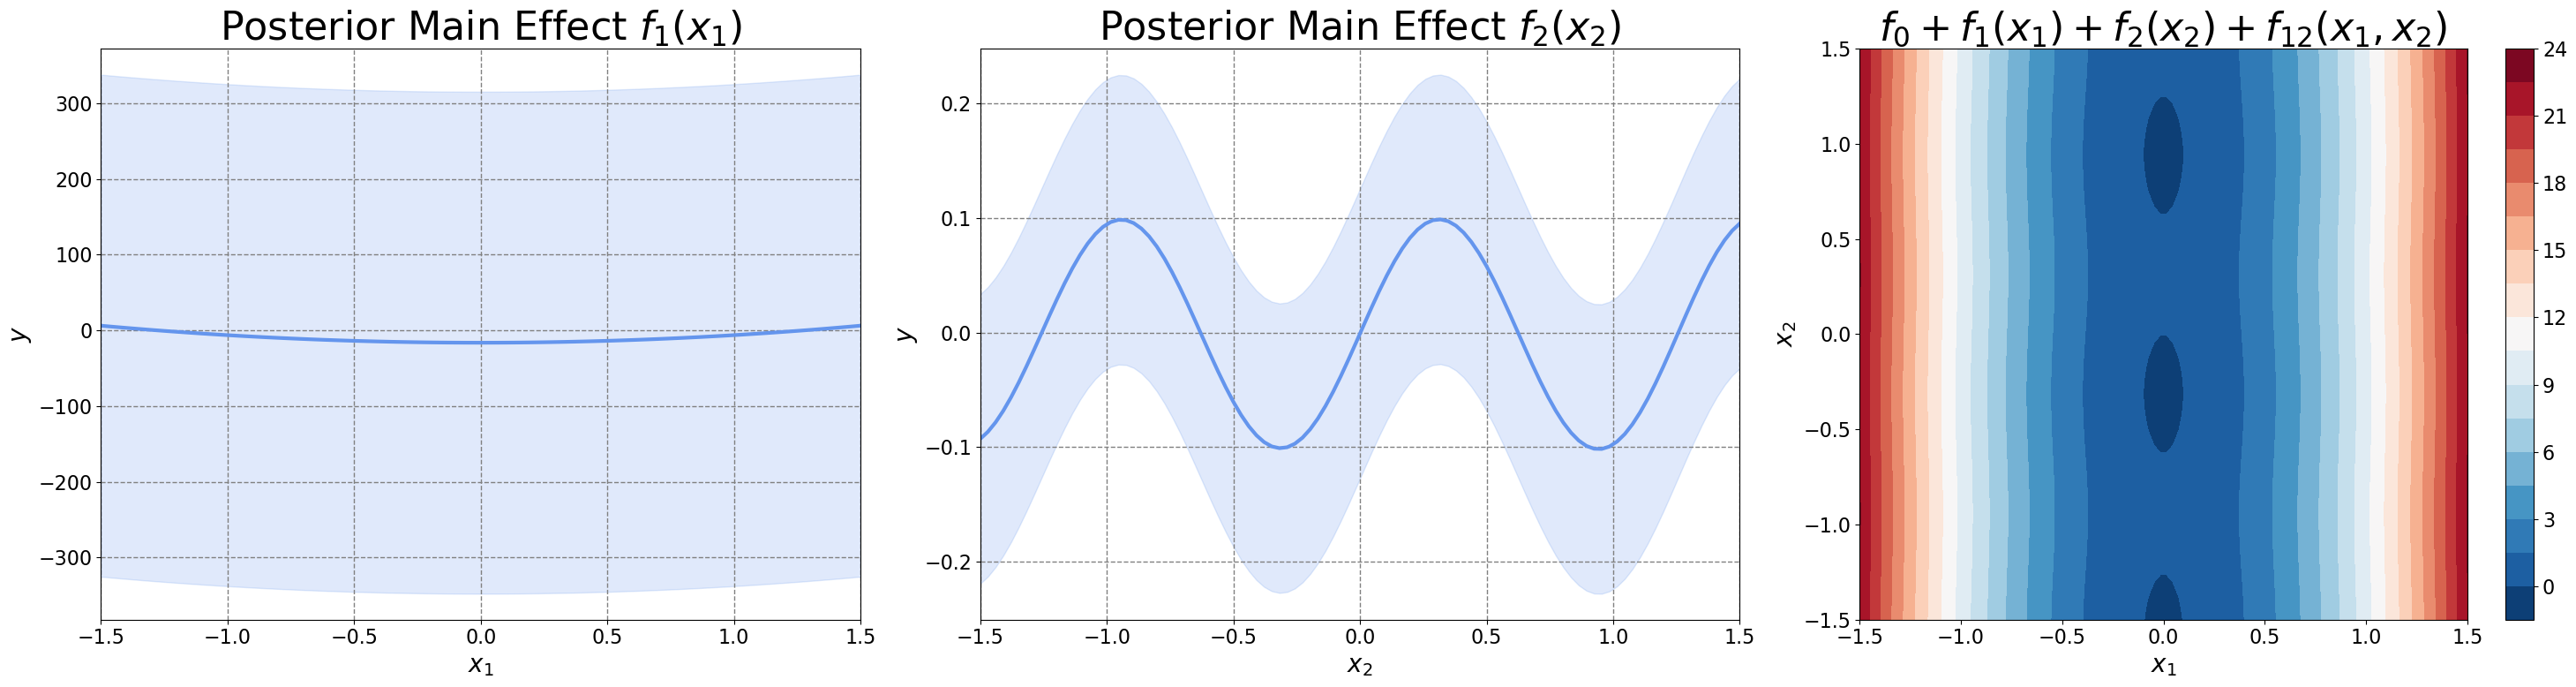

In [38]:
alpha = get_model_sufficient_statistics(model, get_L=False)
X_train = model.data[0]

# --- Create grid for plotting ---
x1_plot = np.linspace(-1.5, 1.5, 100)
x2_plot = np.linspace(-1.5, 1.5, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)

# --- Evaluate each component on the grid ---
f0_kernel = BiasKernel(model.kernel.sigma0_sq.numpy())
f1_kernel = MainEffectKernel(model.kernel.k1, model.kernel.sigma1_sq.numpy())
f2_kernel = MainEffectKernel(model.kernel.k2, model.kernel.sigma1_sq.numpy())
f12_kernel = InteractionKernel(model.kernel.k1, model.kernel.k2, model.kernel.sigma2_sq.numpy())

f0_mean_norm = eval_component(f0_kernel, alpha, X_grid, X_train).reshape(X1_grid.shape)
f1_mean_norm = eval_component(f1_kernel, alpha, X_grid, X_train).reshape(X1_grid.shape)
f2_mean_norm = eval_component(f2_kernel, alpha, X_grid, X_train).reshape(X1_grid.shape)
f12_mean_norm = eval_component(f12_kernel, alpha, X_grid, X_train).reshape(X1_grid.shape)

# De-normalize
f0 = f0_mean_norm * y_std + y_mean
f1 = f1_mean_norm * y_std
f2 = f2_mean_norm * y_std
f12 = f12_mean_norm * y_std


X1_line = np.stack([x1_plot, np.zeros_like(x1_plot)], axis=1)
X2_line = np.stack([np.zeros_like(x2_plot), x2_plot], axis=1)
f1_plot = eval_component(f1_kernel, alpha, X1_line, X_train).flatten() * y_std
f2_plot = eval_component(f2_kernel, alpha, X2_line, X_train).flatten() * y_std
f12_true = true_f12(X_grid).reshape(X1_grid.shape)


K_yy = model.kernel(X_train) + tf.eye(X_train.shape[0], dtype=gpflow.default_float()) * model.likelihood.variance

var_f1_norm = get_component_variance(f1_kernel, K_yy, X1_line, X_train)
std_f1 = np.sqrt(var_f1_norm.numpy()) * y_std 
var_f2_norm = get_component_variance(f2_kernel, K_yy, X2_line, X_train)
std_f2 = np.sqrt(var_f2_norm.numpy()) * y_std
var_f12_norm = get_component_variance(f12_kernel, K_yy, X_grid, X_train)
std_f12 = np.sqrt(var_f12_norm.numpy()).reshape(X1_grid.shape) * y_std

f_sum = f0 + f1 + f2 + f12
f_true = true_function(X_grid).reshape(X1_grid.shape)



# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

# f1
axes[0].plot(x1_plot, f1_plot, label='Posterior $f_1(x_1) \\pm 2$ stds', color='cornflowerblue', lw=3)
axes[0].fill_between(x1_plot, f1_plot - 2 * std_f1, f1_plot + 2 * std_f1, color='cornflowerblue', alpha=0.2)
#axes[0].plot(x1_plot, true_f1(x1_plot), label='Ground Truth', color='darkred')
axes[0].set_title("Posterior Main Effect $f_1(x_1)$")
axes[0].grid(True)
axes[0].set_xlim([-1.5,1.5])
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$y$')
#axes[0].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)

# f2
axes[1].plot(x2_plot, f2_plot, label='Posterior $f_2(x_2) \\pm 2$ stds', color='cornflowerblue', lw=3)
axes[1].fill_between(x2_plot, f2_plot - 2 * std_f2, f2_plot + 2 * std_f2, color='cornflowerblue', alpha=0.2)
#axes[1].plot(x2_plot, true_f2(x2_plot), label='Ground Truth', color='darkred')
axes[1].set_title("Posterior Main Effect $f_2(x_2)$")
axes[1].grid(True)
axes[1].set_xlim([-1.5,1.5])
axes[1].set_xlabel('$x_2$')
axes[1].set_ylabel('$y$')
#axes[1].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)

# f_total
cont_sum = axes[2].contourf(X1_grid, X2_grid, f_sum, levels=20, cmap='RdBu_r')
axes[2].set_title("$f_0 + f_1(x_1) + f_2(x_2) + f_{12}(x_1, x_2)$")
fig.colorbar(cont_sum, ax=axes[2])
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')


plt.tight_layout()
plt.show()

In [39]:
# --- Create AGP model ---
data = (X, y)
model = create_model_oak(
        data=data,
        max_interaction_depth=2,
        constrain_orthogonal=False,
        share_var_across_orders=True,
        use_sparsity_prior=False,
)

# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))

# --- Print model summary ---
gpflow.utilities.print_summary(model)


model_nll = model.training_loss()
print(f"NLL is {model_nll}")

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │          value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   3.87995      │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.12906      │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.variances[0]            │ Parameter │ Softplus         │         │ Tru

In [40]:
N = 10000
X_samples = np.random.normal(0, 1, size=(N, 2))
X_train = model.data[0].numpy()
alpha = get_model_sufficient_statistics(model, get_L=False)
selected_dims, kernel_list = get_list_representation(model.kernel, num_dims=2)



# --- Meshgrid for plotting ---
x1_plot = np.linspace(-1.5, 1.5, 100)
x2_plot = np.linspace(-1.5, 1.5, 100)
X1_grid, X2_grid = np.meshgrid(x1_plot, x2_plot)
X_grid = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)
X_grid_tf = tf.convert_to_tensor(X_grid, dtype=tf.float64)
X_grid_f1 = np.stack([X1_grid.ravel(), np.zeros_like(X1_grid).ravel()], axis=1)
X_grid_f1_tf = tf.convert_to_tensor(X_grid_f1, dtype=tf.float64)
X_grid_f2 = np.stack([np.zeros_like(X2_grid).ravel(), X2_grid.ravel()], axis=1)
X_grid_f2_tf = tf.convert_to_tensor(X_grid_f2, dtype=tf.float64)


# --- Build inputs with fixed variables for f1 and f2 ---
X_plot_f1 = np.copy(X_grid)
X_plot_f1[:, 1] = 0
X_plot_f2 = np.copy(X_grid)
X_plot_f2[:, 0] = 0
X_plot_f12 = X_grid


# --- Evaluate function ---
f0_vals = eval_component(kernel_list[0], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f1_vals = eval_component(kernel_list[1], alpha, tf.convert_to_tensor(X_plot_f1, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f2_vals = eval_component(kernel_list[2], alpha, tf.convert_to_tensor(X_plot_f2, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)
f12_vals = eval_component(kernel_list[3], alpha, tf.convert_to_tensor(X_plot_f12, dtype=tf.float64), tf.convert_to_tensor(X_train, dtype=tf.float64)).reshape(X1_grid.shape)


# --- Posterior Variances ---
K_yy = model.kernel.K(X_train, X_train) + tf.eye(len(X_train), dtype=tf.float64) * model.likelihood.variance.numpy()

# Variance for f0
var_f0_tensor = get_component_variance(kernel_list[0], K_yy, X_grid_tf, X_train)
var_f0 = var_f0_tensor.numpy().reshape(100, 100)
std_f0 = np.sqrt(var_f0) * y_std

# Variance for f1
var_f1_tensor = get_component_variance(kernel_list[1], K_yy, X_grid_f1_tf, X_train)
var_f1 = var_f1_tensor.numpy().reshape(100, 100)
std_f1 = np.sqrt(np.mean(var_f1, axis=0)) * y_std

# Variance for f2
var_f2_tensor = get_component_variance(kernel_list[2], K_yy, X_grid_f2_tf, X_train)
var_f2 = var_f2_tensor.numpy().reshape(100, 100)
std_f2 = np.sqrt(np.mean(var_f2, axis=0)) * y_std

# Variance for f12
var_f12_tensor = get_component_variance(kernel_list[3], K_yy, X_grid_tf, X_train)
var_f12 = var_f12_tensor.numpy().reshape(100, 100)
std_f12 = np.sqrt(var_f12) * y_std

# Variance for the overall model
var_overall_tensor = get_component_variance(model.kernel, K_yy, X_grid_tf, X_train)
var_overall = var_overall_tensor.numpy().reshape(100, 100)
std_overall = np.sqrt(var_overall) * y_std




# --- Denorrmalise ---
f_sum = (f0_vals + f1_vals + f2_vals + f12_vals) * y_std + y_mean
f0_vals = f0_vals * y_std + y_mean
f1_vals = f1_vals * y_std
f2_vals = f2_vals * y_std
f12_vals = f12_vals * y_std
f_true = true_function(X_grid).reshape(100,100)


# --- 1D plots of f1(x1), f2(x2) ---
f1_x1 = np.mean(f1_vals, axis=0)
f2_x2 = np.mean(f2_vals, axis=1)

f12_x1 = np.mean(f12_vals, axis=0)
f12_x2 = np.mean(f12_vals, axis=1)

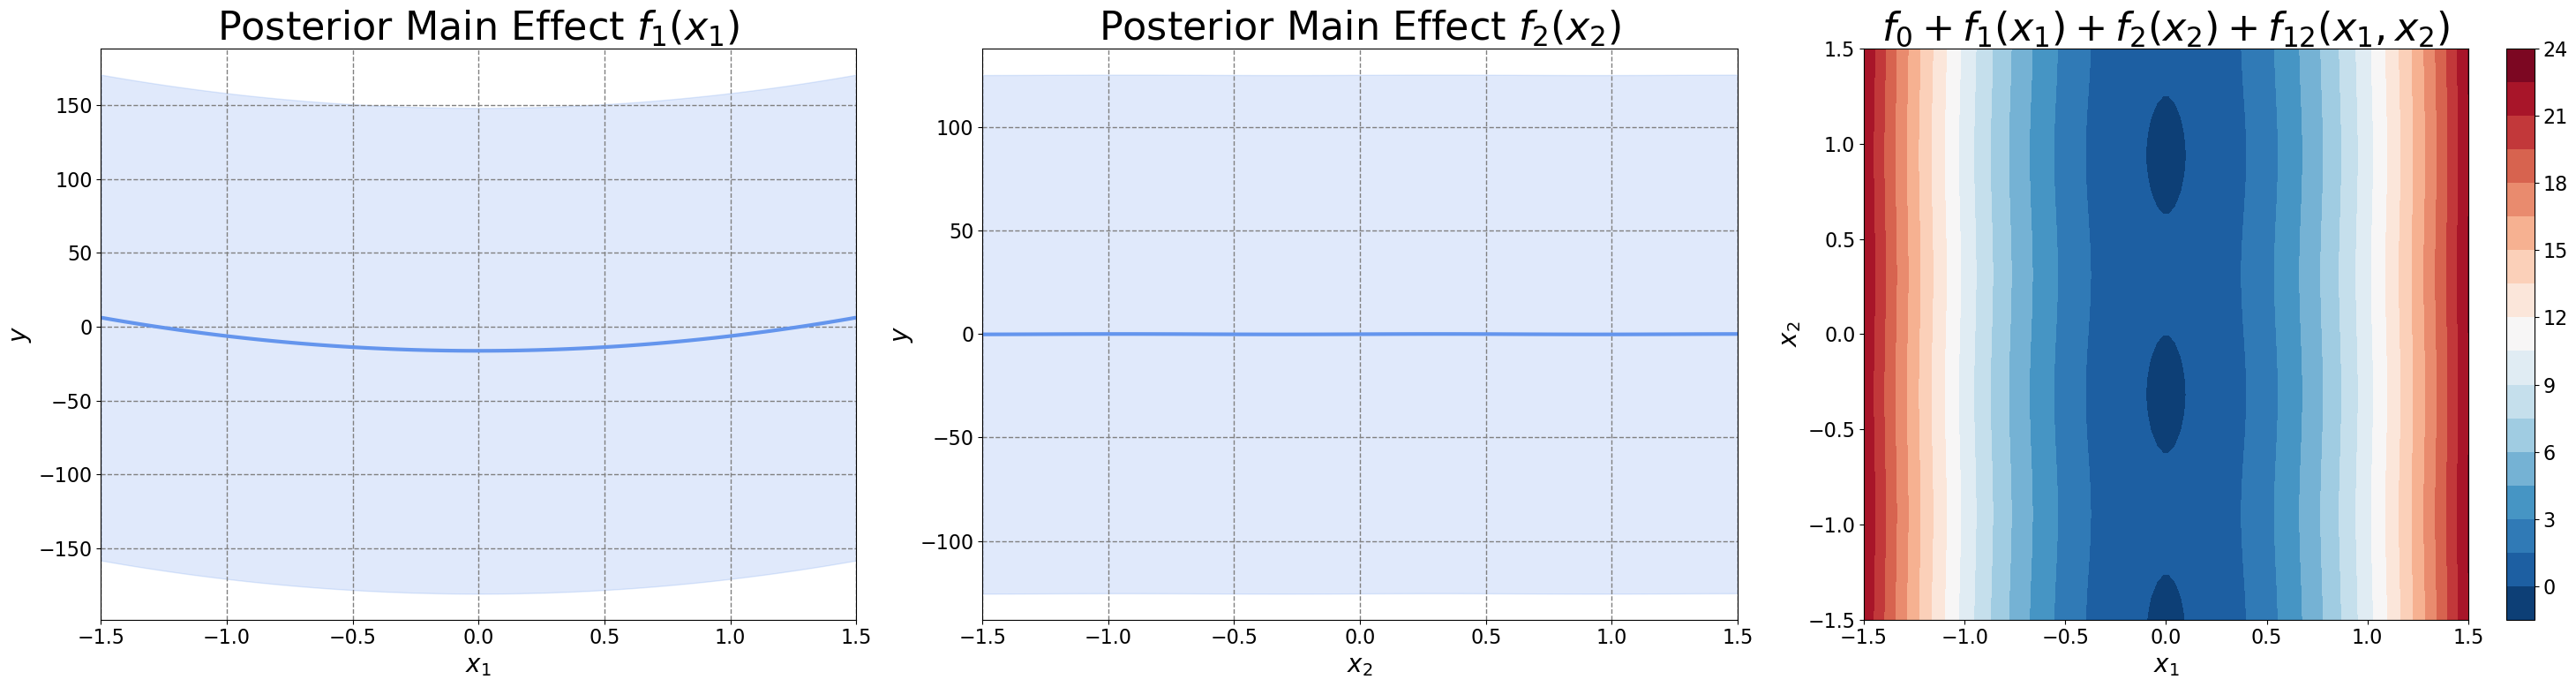

In [41]:
# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(30, 8))

# f1
axes[0].plot(x1_plot, f1_plot, label='Posterior $f_1(x_1) \\pm 2$ stds', color='cornflowerblue', lw=3)
axes[0].fill_between(x1_plot, f1_plot - 2 * std_f1, f1_plot + 2 * std_f1, color='cornflowerblue', alpha=0.2)
#axes[0].plot(x1_plot, true_f1(x1_plot), label='Ground Truth', color='darkred')
axes[0].set_title("Posterior Main Effect $f_1(x_1)$")
axes[0].grid(True)
axes[0].set_xlim([-1.5,1.5])
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$y$')
#axes[0].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)

# f2
axes[1].plot(x2_plot, f2_plot, label='Posterior $f_2(x_2) \\pm 2$ stds', color='cornflowerblue', lw=3)
axes[1].fill_between(x2_plot, f2_plot - 2 * std_f2, f2_plot + 2 * std_f2, color='cornflowerblue', alpha=0.2)
#axes[1].plot(x2_plot, true_f2(x2_plot), label='Ground Truth', color='darkred')
axes[1].set_title("Posterior Main Effect $f_2(x_2)$")
axes[1].grid(True)
axes[1].set_xlim([-1.5,1.5])
axes[1].set_xlabel('$x_2$')
axes[1].set_ylabel('$y$')
#axes[1].legend(loc='upper left', frameon=True, shadow=True, fancybox=True, framealpha=0.9)

# f_total
cont_sum = axes[2].contourf(X1_grid, X2_grid, f_sum, levels=20, cmap='RdBu_r')
axes[2].set_title("$f_0 + f_1(x_1) + f_2(x_2) + f_{12}(x_1, x_2)$")
fig.colorbar(cont_sum, ax=axes[2])
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')


plt.tight_layout()
plt.show()